In [1]:
import numpy as np
import sd as SD
import pickle
import metrics as M
import matplotlib.pyplot as plt
import plot_metrics as PM
import seaborn as sns
from tqdm import tqdm

sns.set_theme(style="whitegrid", context="talk")

In [2]:
with open("lines.pickle", "rb") as f: # 'rb' for read binary
    lines = pickle.load(f)

In [3]:
NUM_CREWS = 35
NUM_LINES = len(lines)
NUM_FEATURES = 3

F = np.zeros((NUM_FEATURES, NUM_LINES))

# create feature matrix
for id, line in lines.items():
    num_legs = line["num_legs"]
    overnights = line["overnights"]
    credit_hours = line["flight_time"]
    features = np.array([num_legs, overnights, credit_hours])
    F[:, id] = features

# normalize by row
for i in range(NUM_FEATURES):
    F[i, :] = F[i, :] / np.linalg.norm(F[i, :], ord=2)

In [4]:
# ----------------------------------------------------
# 	    ORDER GENERATORS
# ----------------------------------------------------

def preference_generator(rng, num_agents, num_features):
    """
    Generate positive-only, heterogeneous agent preferences.
    Produces stable tatonnement behavior and avoids agents wanting nothing.
    """
    
    # --- Step 1: Define heterogeneous preference clusters ---
    cluster_centers = np.array([
        [1.2, 0.6, 0.8],   # Type A: CH-heavy, also likes other features
        [0.8, 1.4, 0.5],   # Type B: overnight-like (if relevant later)
        [0.5, 0.7, 1.8],   # Type C: strongly credit-hour oriented
        [1.0, 1.0, 1.0],   # Type D: balanced
        [0.4, 1.6, 0.6],   # Type E: prefers fewer legs, more rest
    ])
    
    K = cluster_centers.shape[0]

    # --- Step 2: Assign agent types ---
    assignments = rng.integers(0, K, size=num_agents)

    # --- Step 3: Add relatively large noise to diversify preferences ---
    noise = rng.normal(0, 0.4, size=(num_agents, num_features))

    W = cluster_centers[assignments] + noise

    # --- Step 4: Enforce positivity ---
    # Replace any negative weights with small positive values
    W = np.clip(W, a_min=0.05, a_max=None)

    # --- Step 5: Normalize for stability ---
    W = W / np.linalg.norm(W, axis=1, keepdims=True)

    return W


def rank(U):
    return np.argsort(-U, axis=1)


def kband_order_generator(seniority_order, k):
    def gen(rng):
        n = len(seniority_order)
        perm = []

        for start in range(0, n, k):
            band = seniority_order[start:start+k].copy()
            rng.shuffle(band)
            perm.extend(band)

        return np.array(perm, dtype=int)

    return gen


def eps_order_generator(seniority_order, eps):
    def gen(rng):
        n = len(seniority_order)
        noise = rng.normal(0, 1, n)
        ranks = np.arange(n)
        perturbed = ranks + eps * noise
        return seniority_order[np.argsort(perturbed)]

    return gen

In [16]:
# ----------------------------------------------------
# 	    FAIRNESS SIMULATION LOOP
# ----------------------------------------------------
def run_fairness_experiment(F, lines, preference_generator,
                            k_values, eps_values,
                            NUM_SCENARIOS=1000, NUM_TRIALS=100):

    seniority_order = np.arange(NUM_CREWS)
    master_rng = np.random.default_rng(seed=12345)

    fairness_gap_by_band = {k: [] for k in k_values}
    fairness_gap_by_eps = {eps: [] for eps in eps_values}

    mean_total_k = {k: [] for k in k_values}
    mean_total_eps = {eps: [] for eps in eps_values}

    envy_by_k = {k: [] for k in k_values}
    envy_by_eps = {eps: [] for eps in eps_values}

    rsd_total_utils = []


    for s in tqdm(range(NUM_SCENARIOS)):

        scenario_rng = np.random.default_rng(master_rng.integers(1e9))

        # Generate preferences & utilities
        W = preference_generator(rng=scenario_rng, num_agents=NUM_CREWS, num_features=NUM_FEATURES)
        U = W @ F
        P = np.argsort(-U, axis=1)

        # -------- baseline = RSD (k=NUM_CREWS) --------
        n = U.shape[0]
        rsd_rng = np.random.default_rng(scenario_rng.integers(1e9))
        rsd_util = np.zeros(n)

        for _ in range(NUM_TRIALS):
            matches, _ = SD.k_band_serial_dictatorship(P, seniority_order,
                                                     lines, n, rsd_rng)
            rsd_util += M.utilities_per_crew(matches, U)

        rsd_util /= NUM_TRIALS
        gini_rsd = M.gini(rsd_util)

        # Compute total utility for RSD
        rsd_total = 0
        for _ in range(NUM_TRIALS):
            match, _ = SD.k_band_serial_dictatorship(
                P, seniority_order, lines, NUM_CREWS, rng=rsd_rng
            )
            rsd_total += M.total_utility(match, U)
        rsd_total /= NUM_TRIALS
        rsd_total_utils.append(rsd_total)


        # -------- k-band --------
        for k in k_values:
            k_rng = np.random.default_rng(scenario_rng.integers(1e9))
            util_vec = np.zeros(n)
            total_k = 0
            j_envy_vec = np.zeros(n)
            for _ in range(NUM_TRIALS):
                matches, _ = SD.k_band_serial_dictatorship(P, seniority_order,
                                                         lines, k, rng=k_rng)
                util_vec += M.utilities_per_crew(matches, U)
                total_k += M.total_utility(matches, U)
                j_envy_vec += M.justified_envy(seniority_order, U, matches)

            util_vec /= NUM_TRIALS
            total_k /= NUM_TRIALS
            j_envy_vec /= NUM_TRIALS

            fairness_gap_by_band[k].append(M.gini(util_vec) - gini_rsd)
            mean_total_k[k].append(total_k)
            envy_by_k[k].append(j_envy_vec)


        # -------- epsilon noise SD --------
        for eps in eps_values:
            eps_rng = np.random.default_rng(scenario_rng.integers(1e9))
            util_vec = np.zeros(n)
            total_eps = 0
            j_envy_vec = np.zeros(n)
            for _ in range(NUM_TRIALS):
                matches, _ = SD.epsilon_serial_dictatorship(P, seniority_order,
                                                          lines, eps, eps_rng)
                m = np.array([matches[c] for c in seniority_order])
                util_vec += M.utilities_per_crew(matches, U)
                total_eps += M.total_utility(matches, U)
                j_envy_vec += M.justified_envy(seniority_order, U, m)
            util_vec /= NUM_TRIALS
            total_eps /= NUM_TRIALS
            j_envy_vec /= NUM_TRIALS

            fairness_gap_by_eps[eps].append(M.gini(util_vec) - gini_rsd)
            mean_total_eps[eps].append(total_eps)
            envy_by_eps[eps].append(j_envy_vec)

    # Return means
    mean_gap_k = {k: np.mean(fairness_gap_by_band[k]) for k in k_values}
    mean_gap_eps = {eps: np.mean(fairness_gap_by_eps[eps]) for eps in eps_values}
    se_gap_k = {k: np.std(fairness_gap_by_band[k], ddof=1) / np.sqrt(NUM_SCENARIOS)
            for k in k_values}
    se_gap_eps = {eps: np.std(fairness_gap_by_eps[eps], ddof=1) / np.sqrt(NUM_SCENARIOS)
                for eps in eps_values}
    
    # Return envy
    envy_k = {k: envy_by_k[k] for k in k_values}
    envy_eps = {eps: envy_by_eps[eps] for eps in eps_values}


    # Baseline mean RSD utility
    mean_rsd = np.mean(rsd_total_utils)

    # Compute utility gaps (mechanism – RSD) with SE
    util_gap_k = {}
    util_gap_eps = {}

    for k in k_values:
        arr = np.array(mean_total_k[k]) - mean_rsd
        util_gap_k[k] = (arr.mean(), arr.std(ddof=1) / np.sqrt(len(arr)))

    for eps in eps_values:
        arr = np.array(mean_total_eps[eps]) - mean_rsd
        util_gap_eps[eps] = (arr.mean(), arr.std(ddof=1) / np.sqrt(len(arr)))

    
    results = {
        "mean_gap_k": mean_gap_k,
        "mean_gap_eps": mean_gap_eps,
        "se_gap_k": se_gap_k,
        "se_gap_eps": se_gap_eps,
        "util_gap_k": util_gap_k,
        "util_gap_eps": util_gap_eps,
        "envy_k": envy_k,
        "envy_eps": envy_eps,
    }
    return results

In [17]:

# ----------------------------------------------------
# 	    DISRUPTION CURVES (ABS + SIGNED)
# ----------------------------------------------------
def compute_disruption_curves(k_values, eps_values,
                              seniority_order,
                              trials=3000, seed=999):

    rng = np.random.default_rng(seed)

    disruption = {
        "k_abs": {}, "k_signed": {},
        "eps_abs": {}, "eps_signed": {}
    }

    for k in k_values:
        gen = kband_order_generator(seniority_order, k)
        abs_dev, sgn = M.displacement_metrics(gen, seniority_order, trials, rng)
        disruption["k_abs"][k] = abs_dev
        disruption["k_signed"][k] = sgn

    for eps in eps_values:
        gen = eps_order_generator(seniority_order, eps)
        abs_dev, sgn = M.displacement_metrics(gen, seniority_order, trials, rng)
        disruption["eps_abs"][eps] = abs_dev
        disruption["eps_signed"][eps] = sgn

    return disruption


# ----------------------------------------------------
# 	    FRONTIER PLOTTING
# ----------------------------------------------------
def plot_frontier_abs(rank_i, k_values, eps_values,
                         disruption_k_abs, disruption_eps_abs,
                         mean_gap_k, mean_gap_eps):

    plt.figure(figsize=(10, 7), dpi=140)

    # ------ k-band SD ------
    xs_k = [mean_gap_k[k] for k in k_values]   # fairness on x-axis
    ys_k = [-disruption_k_abs[k][rank_i] for k in k_values]  # displacement on y-axis

    plt.plot(xs_k, ys_k, '-o', color="#E69F00", linewidth=2.5, markersize=12,
             label="k-band SD")

    for x, y, k in zip(xs_k, ys_k, k_values):
        plt.text(x + 0.002, y + 0.05, f"k={k}", fontsize=12, color="#E69F00")

    # ------ epsilon SD ------
    xs_eps = [mean_gap_eps[eps] for eps in eps_values]
    ys_eps = [disruption_eps_abs[eps][rank_i] for eps in eps_values]

    plt.plot(xs_eps, ys_eps, '--s', color="#0072B2", linewidth=2.5, markersize=12,
             label="epsilon SD")

    for x, y, eps in zip(xs_eps, ys_eps, eps_values):
        plt.text(x + 0.002, y - 0.1, f"ε={eps}", fontsize=12, color="#0072B2")

    # Axes + labels
    plt.xlabel("Fairness gap (Gini − Gini(RSD))", fontsize=16)
    plt.ylabel(f"Expected absolute position change (rank {rank_i})", fontsize=16)
    plt.title(f"Seniority disruption required for fairness — rank {rank_i}", fontsize=18)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_frontier_signed(rank_i, k_values, eps_values,
                         disruption_k_signed, disruption_eps_signed,
                         mean_gap_k, mean_gap_eps):

    plt.figure(figsize=(10, 7), dpi=140)

    # ------ k-band SD ------
    xs_k = [mean_gap_k[k] for k in k_values]   # fairness on x-axis
    ys_k = [-disruption_k_signed[k][rank_i] for k in k_values]  # displacement on y-axis

    plt.plot(xs_k, ys_k, '-o', color="#E69F00", linewidth=2.5, markersize=12,
             label="k-band SD")

    for x, y, k in zip(xs_k, ys_k, k_values):
        plt.text(x + 0.002, y + 0.05, f"k={k}", fontsize=12, color="#E69F00")

    # ------ epsilon SD ------
    xs_eps = [mean_gap_eps[eps] for eps in eps_values]
    ys_eps = [-disruption_eps_signed[eps][rank_i] for eps in eps_values]

    plt.plot(xs_eps, ys_eps, '--s', color="#0072B2", linewidth=2.5, markersize=12,
             label="epsilon SD")

    for x, y, eps in zip(xs_eps, ys_eps, eps_values):
        plt.text(x + 0.002, y - 0.1, f"ε={eps}", fontsize=12, color="#0072B2")

    # Axes + labels
    plt.xlabel("Fairness gap (Gini − Gini(RSD))", fontsize=16)
    plt.ylabel(f"Expected position change (rank {rank_i})", fontsize=16)
    plt.title(f"Seniority disruption required for fairness — rank {rank_i}", fontsize=18)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [46]:
# -----------------------------------------
# 1. Choose mechanism parameter grids
# -----------------------------------------
k_values   = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 35]
eps_values = [0, 1, 2, 3, 5, 10, 15, 20, 25, 30, 50, 75, 100]

# -----------------------------------------
# 2. Run fairness + utility experiment
# -----------------------------------------
NUM_SCENARIOS = 100
NUM_TRIALS=100
results = run_fairness_experiment(
    F, lines, preference_generator,
    k_values, eps_values,
    NUM_SCENARIOS=NUM_SCENARIOS,     # adjust for speed/accuracy
    NUM_TRIALS=NUM_TRIALS,         # inner loop trials
)


100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


In [47]:
mean_gap_k   = results["mean_gap_k"]
mean_gap_eps = results["mean_gap_eps"]
util_gap_k   = results["util_gap_k"]
util_gap_eps = results["util_gap_eps"]
se_gap_k = results["se_gap_k"]
se_gap_eps = results["se_gap_eps"]
envy_k = results["envy_k"]
envy_eps = results["envy_eps"]

seniority_order = np.arange(NUM_CREWS)

disruption = compute_disruption_curves(
    k_values, eps_values,
    seniority_order,
    trials=1000, 
    seed=999
)

In [88]:
mean_envies_eps = []
mean_envies_k = []
se_envies_eps = []
se_envies_k = []

for e in eps_values:
    average_envy = np.mean(np.array(envy_eps[e]), axis=0)
    se_envy = np.std(envy_eps[e], ddof=1) / np.sqrt(NUM_SCENARIOS)
    mean_envies_eps.append(average_envy)
    se_envies_eps.append(se_envy)

for k in k_values:
    average_envy = np.mean(np.array(envy_k[k]), axis=0)
    se_envy = np.std(envy_k[k], ddof=1) / np.sqrt(NUM_SCENARIOS)
    mean_envies_k.append(average_envy)
    se_envies_k.append(se_envy)

mean_envies_eps = np.array(mean_envies_eps)
mean_envies_k = np.array(mean_envies_k)
se_envies_eps = np.array(se_envies_eps)
se_envies_k = np.array(se_envies_k)

In [148]:
def plot_envy_curve(k_values, eps_values, mean_envy_k, mean_envy_eps, se_envy_k, se_envy_eps):
    plt.figure(figsize=(10,6), dpi=140)
    means = [np.mean(mean_envy_k[k]) for k, k_value in enumerate(k_values)]
    ses   = [se_envy_k[k] for k, k_value in enumerate(k_values)]

    plt.errorbar(k_values, means, yerr=1.96*np.array(ses),
                 fmt="-o", color="#E69F00", capsize=5, label="Tiered RSD")
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel("Tier Size k")
    plt.ylabel("Avg. Justified Envy Counts")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,6), dpi=140)
    means = [np.mean(mean_envy_eps[eps]) for eps, eps_value in enumerate(eps_values)]
    ses   = [se_envy_eps[eps] for eps, eps_value in enumerate(eps_values)]

    plt.errorbar(eps_values, means, yerr=1.96*np.array(ses),
                 fmt="-o", color="#0072B2", capsize=5, label="ε-Noisy RSD")
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel("ε (Noise Parameter)")
    plt.ylabel("Avg. Justified Envy Counts")
    plt.legend()
    plt.tight_layout()
    plt.show()

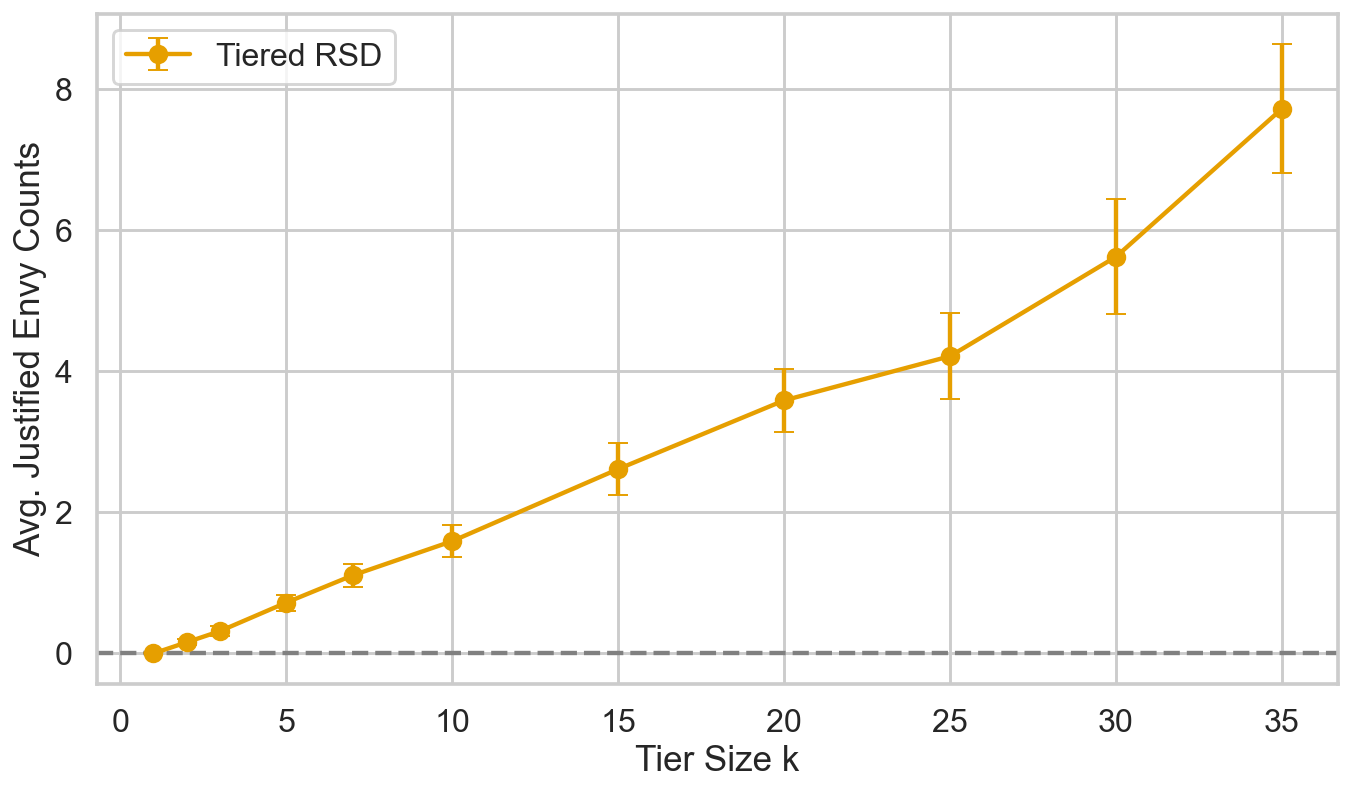

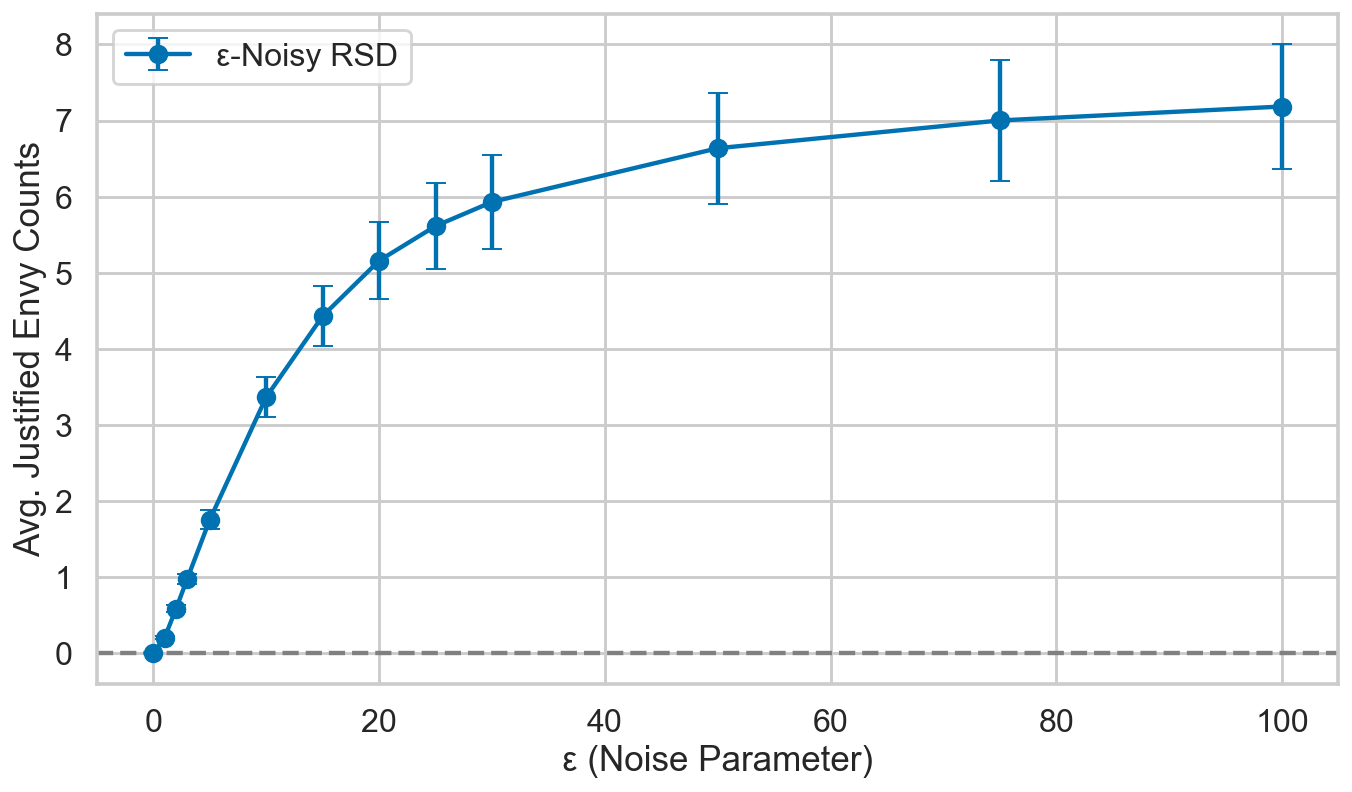

In [149]:
plot_envy_curve(k_values, eps_values, mean_envies_k, mean_envies_eps, se_envies_k, se_envies_eps)

In [147]:
def plot_utility_gap(k_values, eps_values, util_gap_k, util_gap_eps):
    # --- k-band ---
    plt.figure(figsize=(10,6), dpi=140)
    means = [util_gap_k[k][0] for k in k_values]
    ses   = [util_gap_k[k][1] for k in k_values]

    plt.errorbar(k_values, means, yerr=1.96*np.array(ses),
                 fmt="-o", color="#E69F00", capsize=5, label="Tiered RSD")
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel("Tier Size k")
    plt.ylabel("Utility Gap (vs RSD)")
    plt.tight_layout()
    plt.legend()
    plt.show()

    # --- epsilon ---
    plt.figure(figsize=(10,6), dpi=140)
    means = [util_gap_eps[e][0] for e in eps_values]
    ses   = [util_gap_eps[e][1] for e in eps_values]

    plt.errorbar(eps_values, means, yerr=1.96*np.array(ses),
                 fmt="--s", color="#0072B2", capsize=5, label="ε-Noisy RSD")
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel("ε (Noise Parameter)")
    plt.ylabel("Utility Gap (vs RSD)")
    plt.tight_layout()
    plt.legend()
    plt.show()

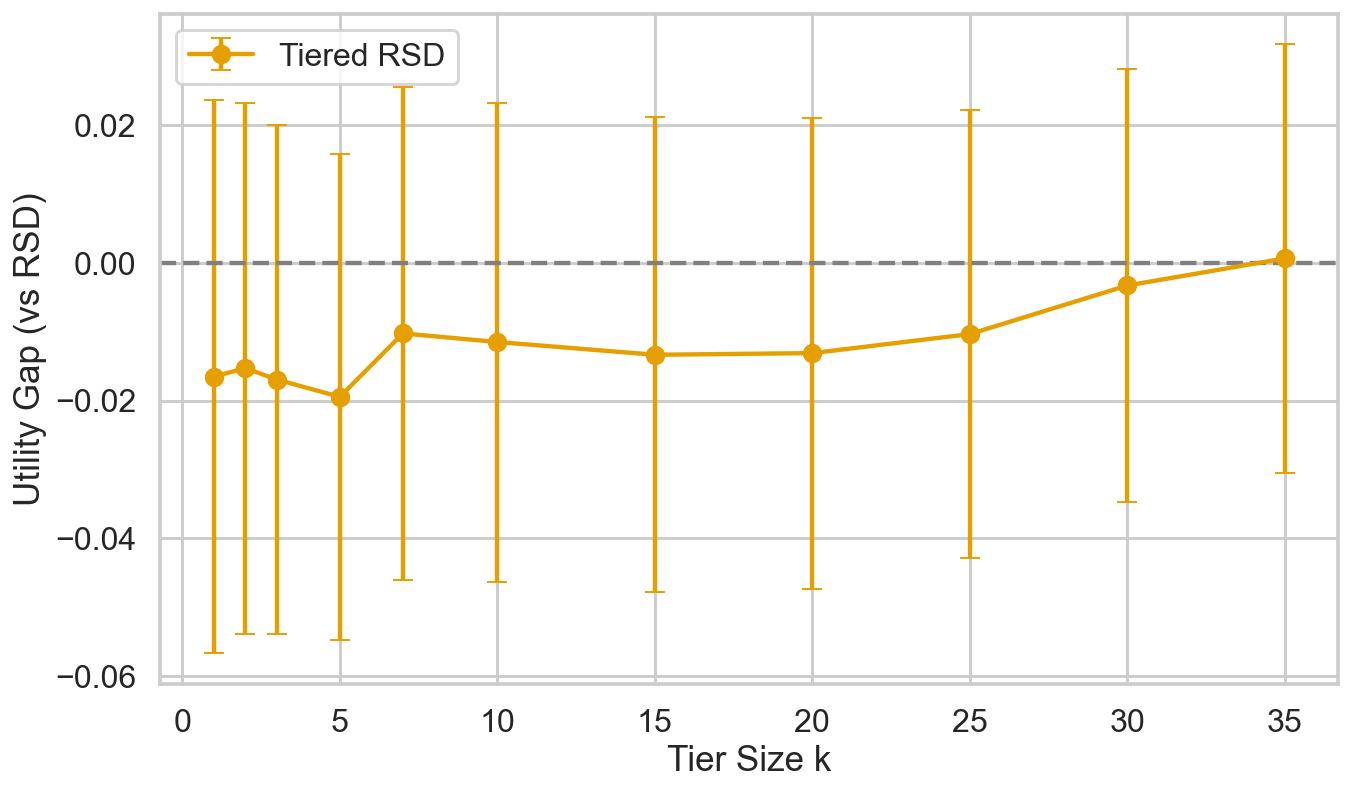

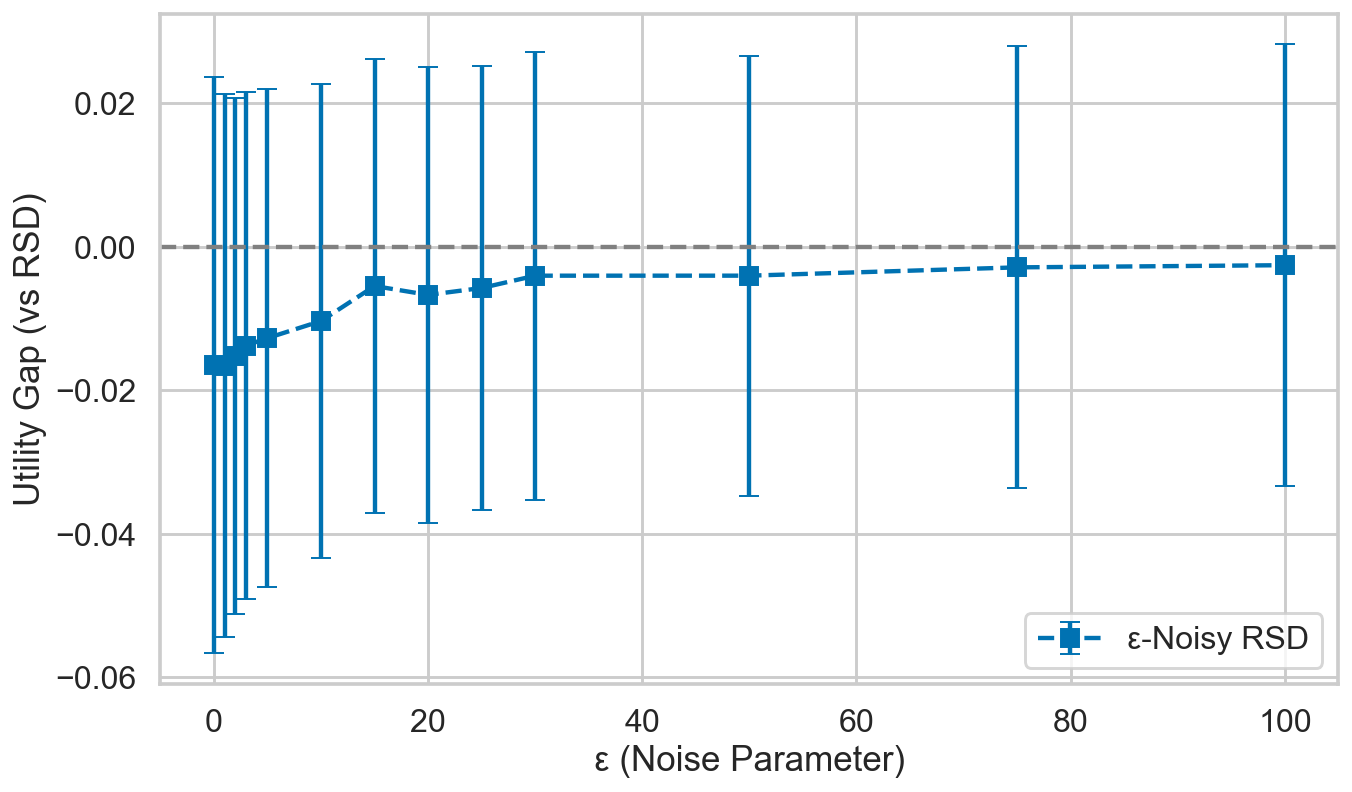

In [146]:
plot_utility_gap(
    k_values, eps_values,
    util_gap_k, util_gap_eps
)


In [141]:
def plot_fairness_k(k_values, mean_gap_k, se_gap_k=None):
    plt.figure(figsize=(10,6), dpi=140)

    means = [mean_gap_k[k] for k in k_values]

    if se_gap_k is not None:
        ses = [se_gap_k[k] for k in k_values]
        plt.errorbar(
            k_values, means,
            yerr=1.96*np.array(ses),
            fmt='-o', capsize=5,
            color="#E69F00", linewidth=2.5,
            label="Tiered RSD"
        )
    else:
        plt.plot(k_values, means, '-o',
                 color="#E69F00", linewidth=2.5, label="Tiered RSD")

    plt.axhline(0, linestyle='--', color='gray')

    plt.xlabel("Tier Size k", fontsize=15)
    plt.ylabel("Fairness Gap (Gini − Gini(RSD))", fontsize=15)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_fairness_eps(eps_values, mean_gap_eps, se_gap_eps=None):
    plt.figure(figsize=(10,6), dpi=140)

    means = [mean_gap_eps[e] for e in eps_values]

    if se_gap_eps is not None:
        ses = [se_gap_eps[e] for e in eps_values]
        plt.errorbar(
            eps_values, means,
            yerr=1.96*np.array(ses),
            fmt='--s', capsize=5,
            color="#0072B2", linewidth=2.5,
            label="ε-Noisy RSD"
        )
    else:
        plt.plot(eps_values, means, '--s',
                 color="#0072B2", linewidth=2.5, label="ε-Noisy RSD")

    plt.axhline(0, linestyle='--', color='gray')

    plt.xlabel("ε (Noise Parameter)", fontsize=15)
    plt.ylabel("Fairness Gap (Gini − Gini(RSD))", fontsize=15)
    plt.legend()
    plt.tight_layout()
    plt.show()

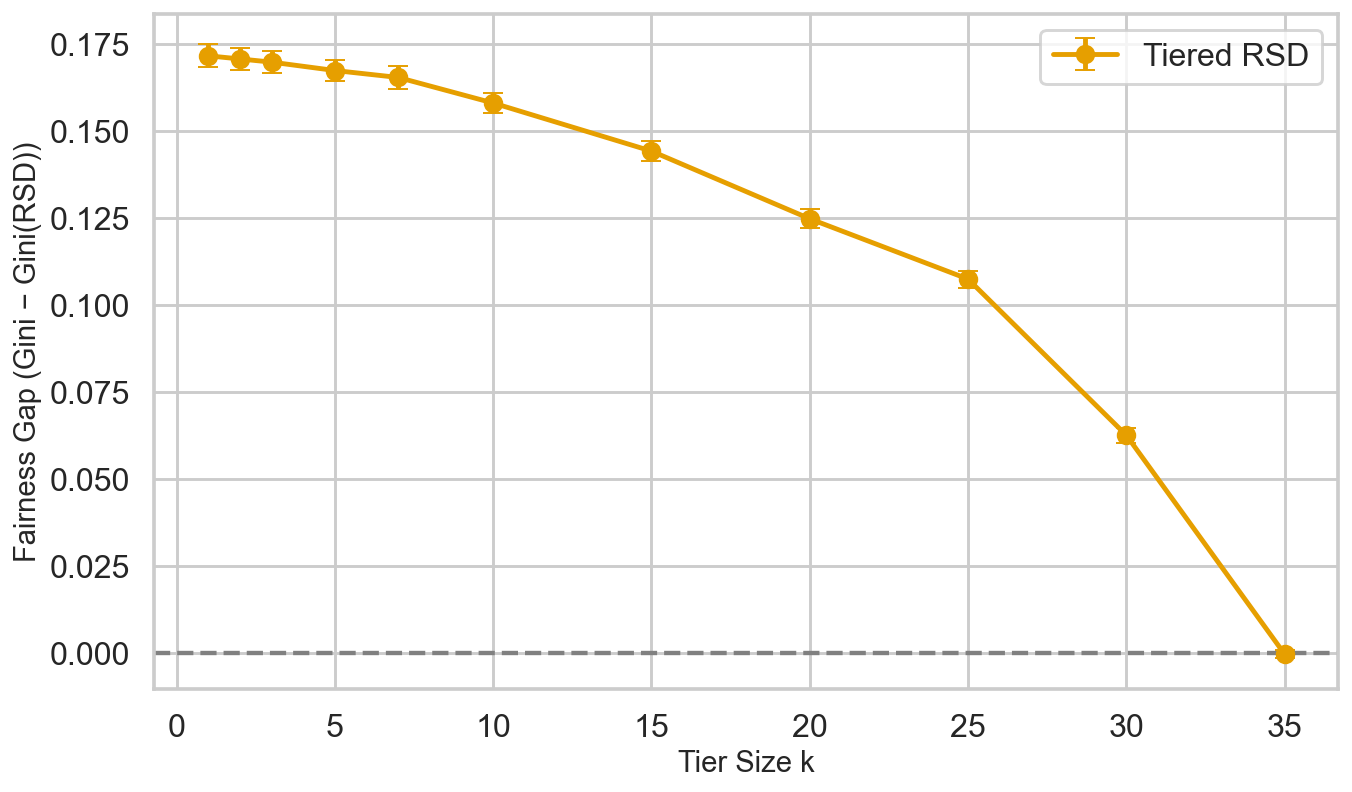

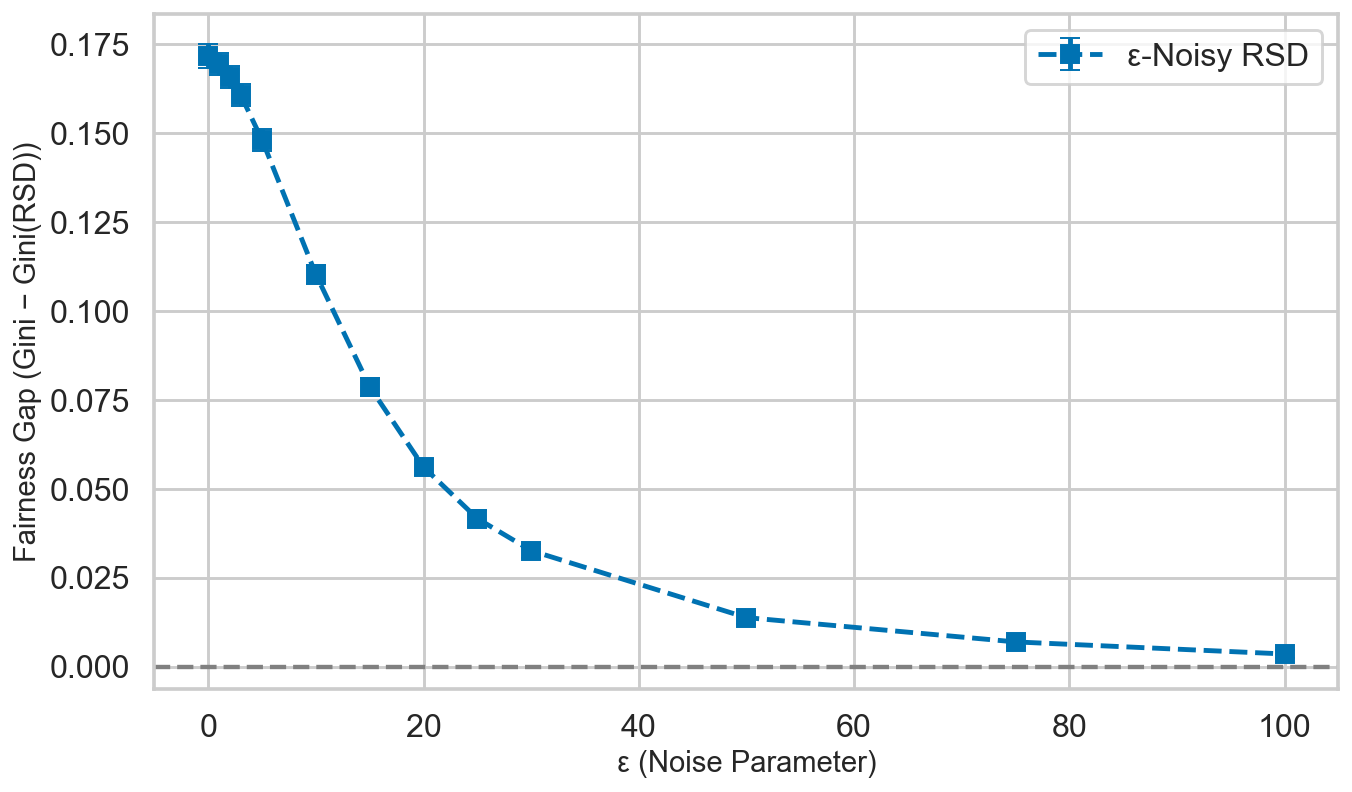

In [142]:
# example: compute SE for fairness
plot_fairness_k(k_values, mean_gap_k, se_gap_k)
plot_fairness_eps(eps_values, mean_gap_eps, se_gap_eps)


In [150]:
def plot_fairness_displacement_frontier(rank_i, k_values, eps_values,
                  mean_gap_k, mean_gap_eps,
                  disruption, signed=True):

    plt.figure(figsize=(10,7), dpi=140)

    if signed:
        disp_k = disruption["k_signed"]
        disp_e = disruption["eps_signed"]
        ylabel = f"Expected Signed Displacement (Rank {rank_i})"

    else:
        disp_k = disruption["k_abs"]
        disp_e = disruption["eps_abs"]
        ylabel = f"Expected Absolute Displacement (Rank {rank_i})"

    # --- k-band ---
    xs = [mean_gap_k[k] for k in k_values]
    if signed:
        ys = [-disp_k[k][rank_i] for k in k_values]
    else:
        ys = [disp_k[k][rank_i] for k in k_values]

    plt.plot(xs, ys, '-o', color="#E69F00", label="Tiered RSD")
    for x, y, k in zip(xs, ys, k_values):
        plt.text(x+0.002, y+0.03, f"k={k}", color="#E69F00")

    # --- epsilon ---
    xs = [mean_gap_eps[e] for e in eps_values]
    if signed:
        ys = [-disp_e[e][rank_i] for e in eps_values]
    else:
        ys = [disp_e[e][rank_i] for e in eps_values]

    plt.plot(xs, ys, '--s', color="#0072B2", label="ε-Noisy RSD")
    for x, y, eps in zip(xs, ys, eps_values):
        plt.text(x+0.002, y-0.05, f"ε={eps}", color="#0072B2")

    plt.xlabel("Fairness Gap (Gini − Gini(RSD))", fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

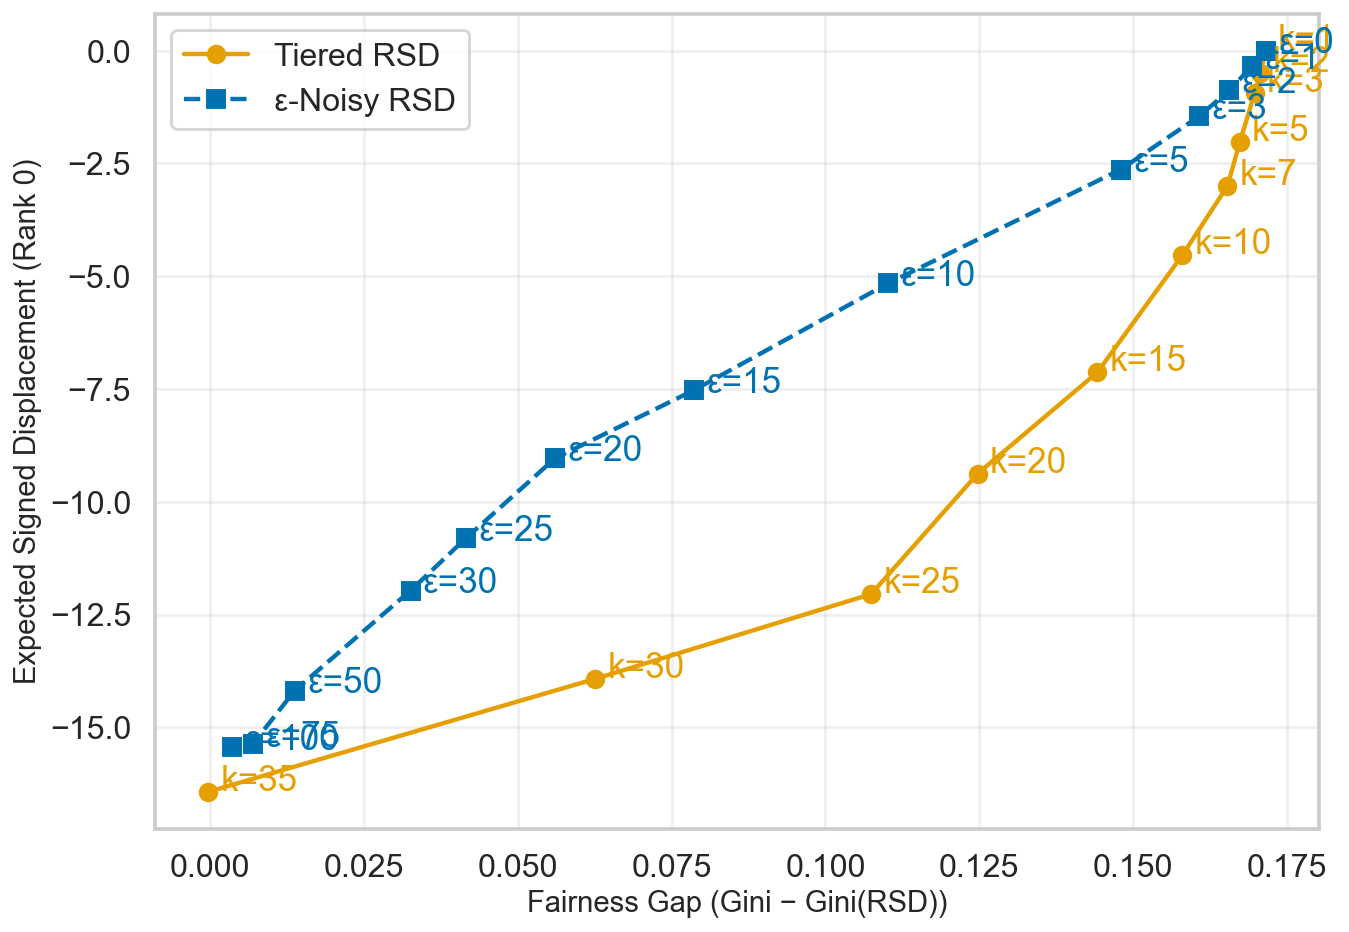

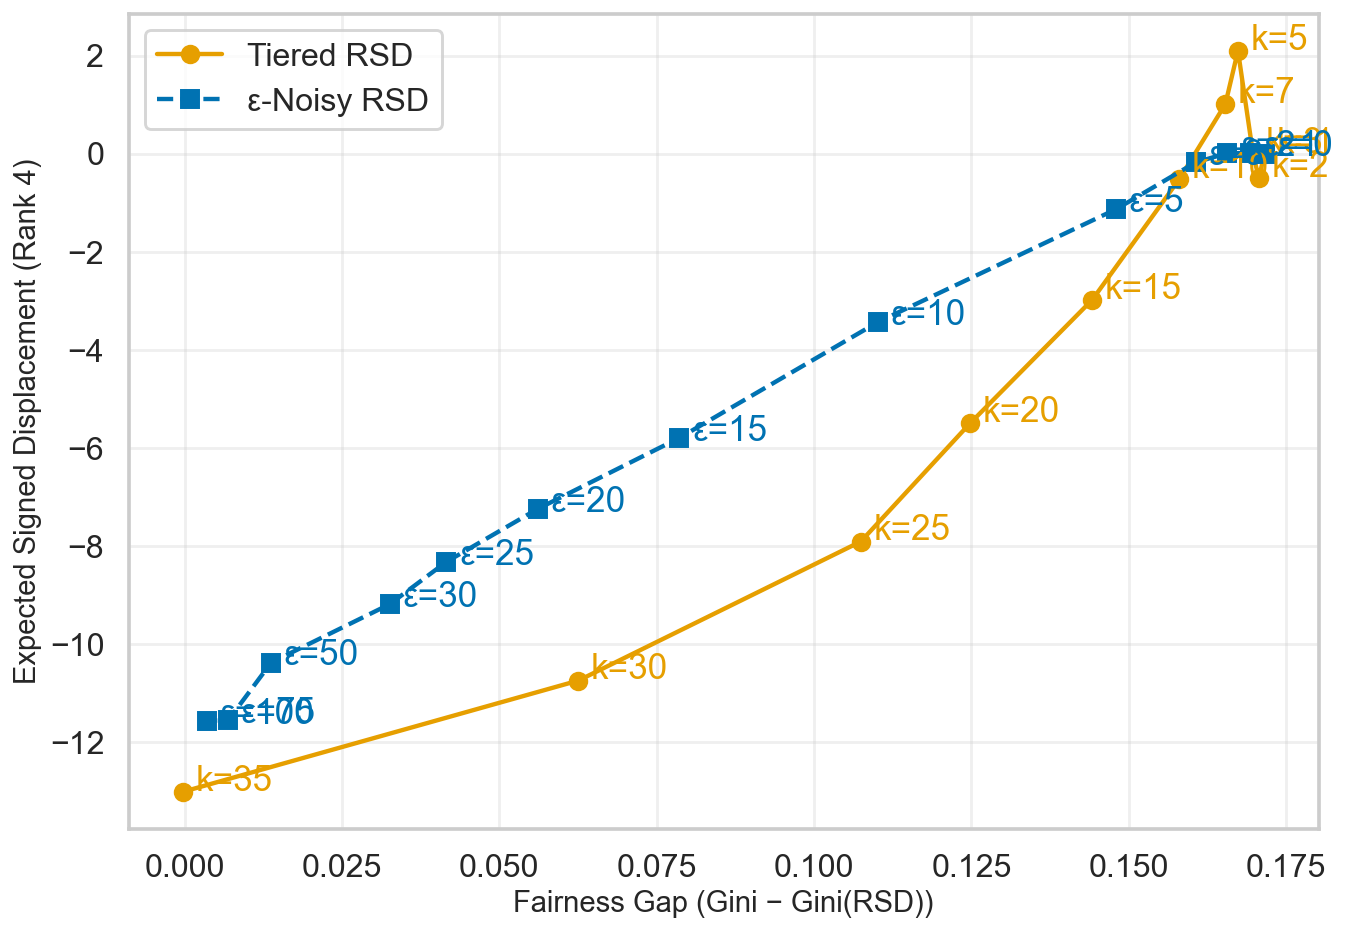

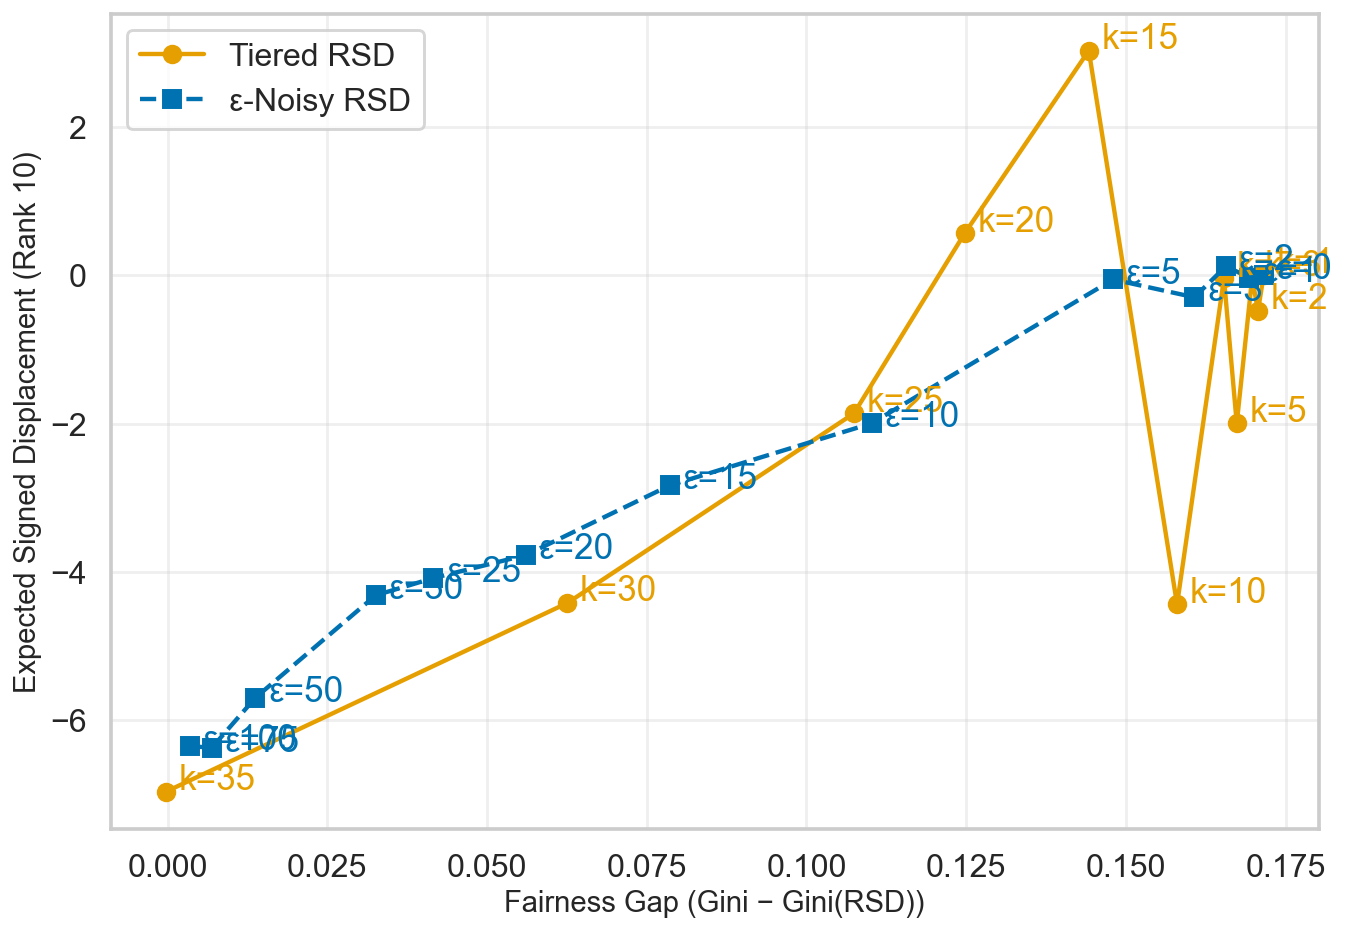

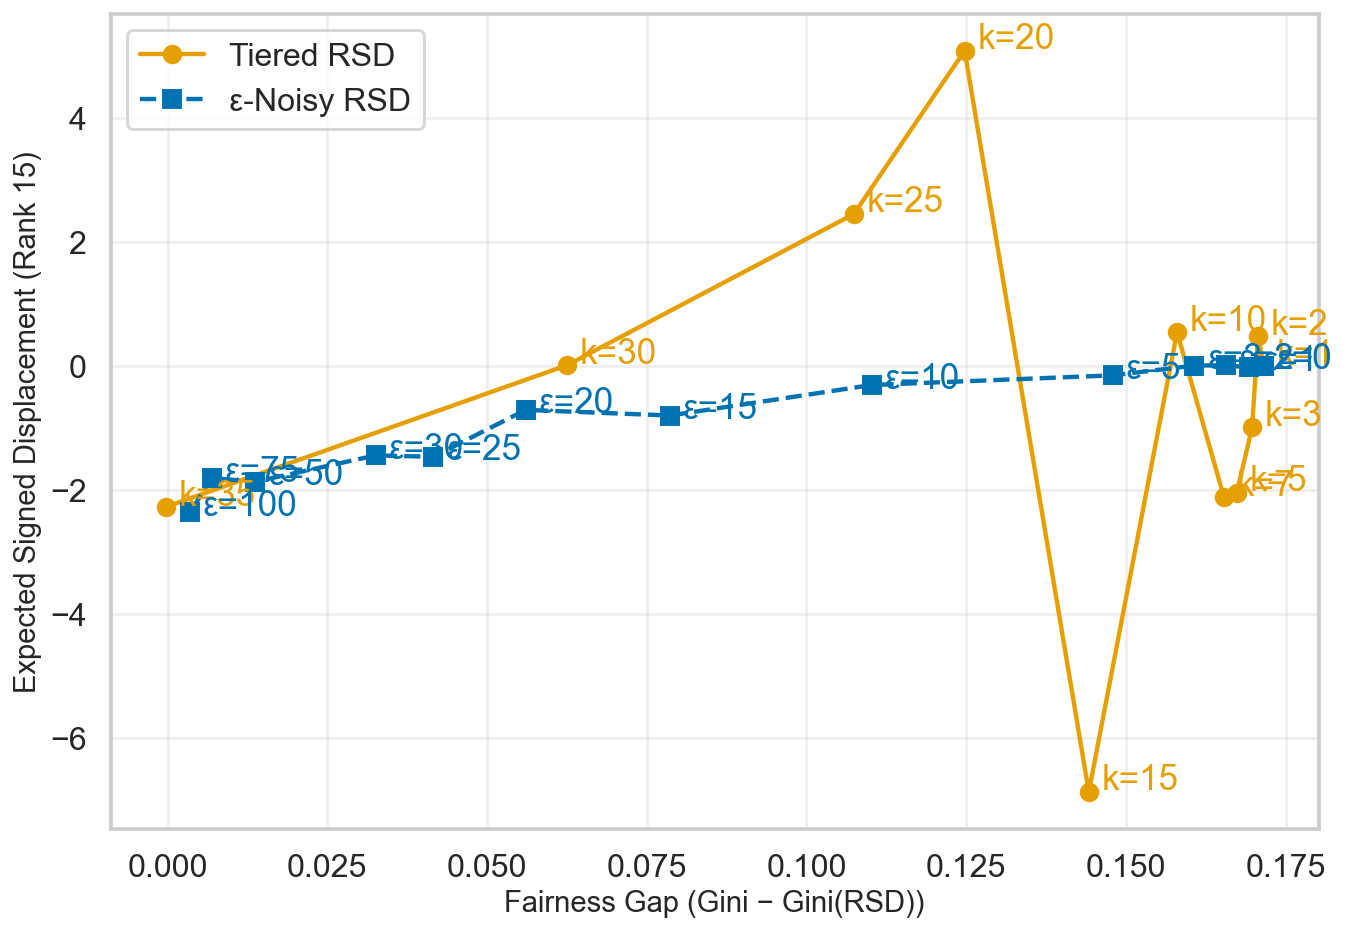

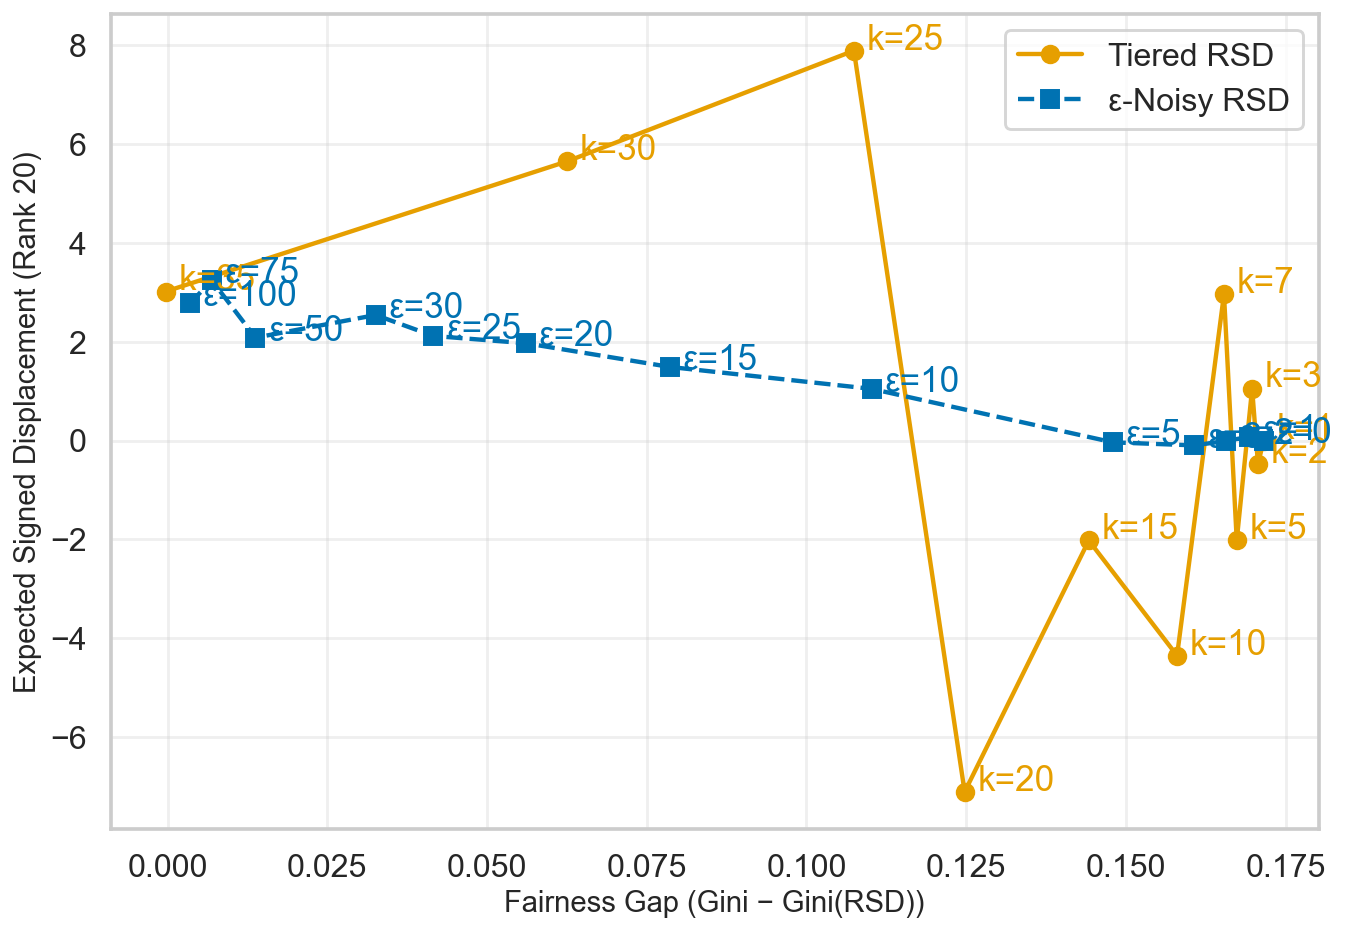

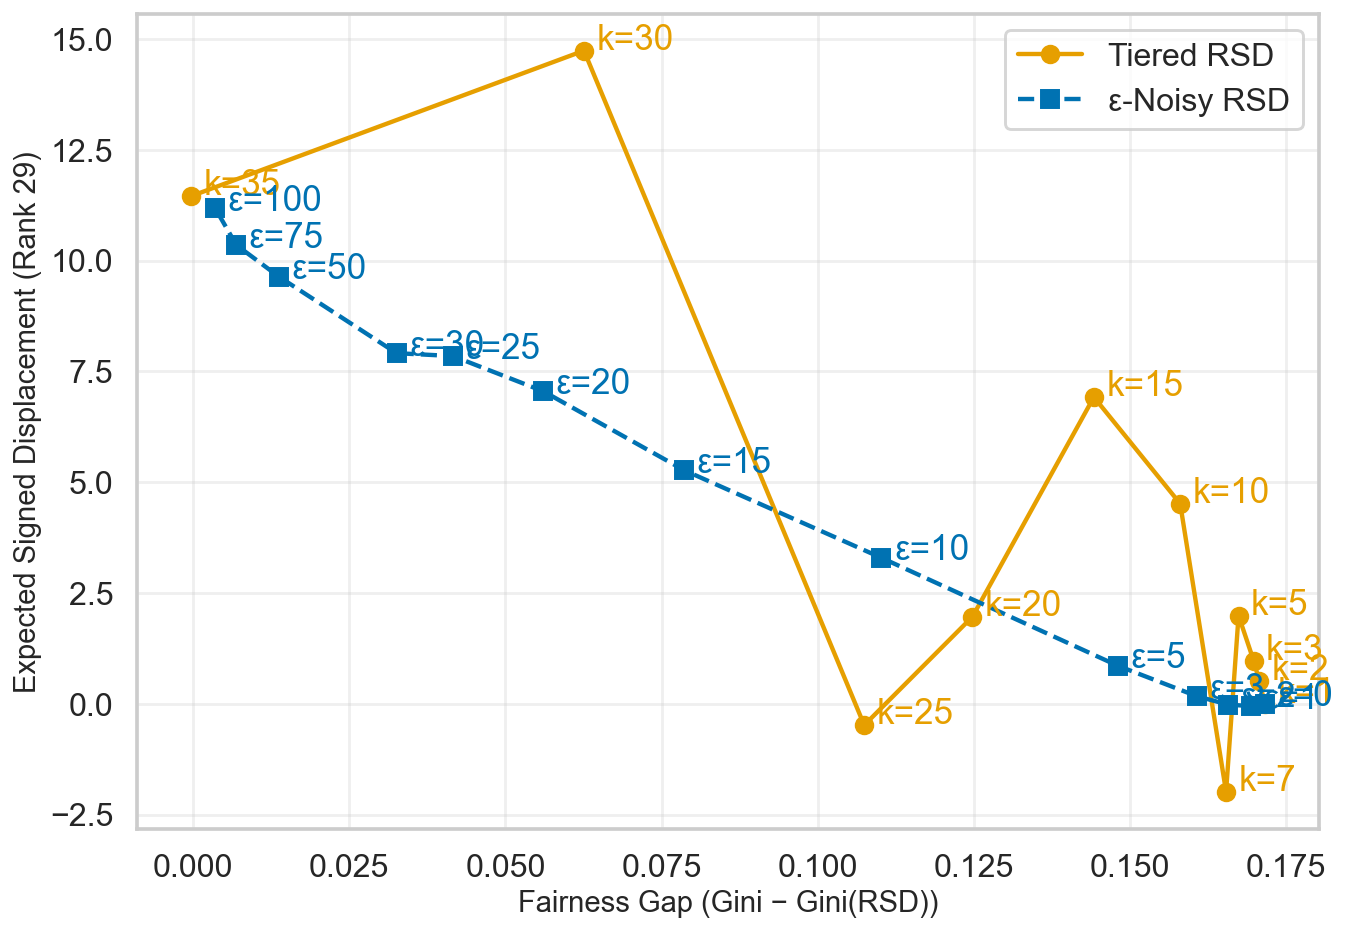

In [152]:
ranks_to_plot = [0, 4, 10, 15, 20, 29]

for r in ranks_to_plot:
    plot_fairness_displacement_frontier(
        rank_i=r,
        k_values=k_values,
        eps_values=eps_values,
        mean_gap_k=mean_gap_k,
        mean_gap_eps=mean_gap_eps,
        disruption=disruption,
        signed=True
    )


In [137]:
def plot_fairness_envy_frontier(rank_i, k_values, eps_values,
                  mean_gap_k, mean_gap_eps,
                  mean_envy_k, mean_envy_eps):

    plt.figure(figsize=(10,7), dpi=140)

    ylabel = f"Avg. Justified Envy (Rank {rank_i})"

    # --- k-band ---
    xs = [mean_gap_k[k] for k in k_values]
    ys = [mean_envy_k[k][rank_i] for k, k_value in enumerate(k_values)]

    plt.plot(xs, ys, '-o', color="#E69F00", label="Tiered RSD")
    for x, y, k in zip(xs, ys, k_values):
        plt.text(x+0.002, y+0.03, f"k={k}", color="#E69F00")

    # --- epsilon ---
    xs = [mean_gap_eps[e] for e in eps_values]
    ys = [mean_envy_eps[e][rank_i] for e, e_value in enumerate(eps_values)]

    plt.plot(xs, ys, '--s', color="#0072B2", label="ε-Noisy RSD")
    for x, y, eps in zip(xs, ys, eps_values):
        plt.text(x+0.002, y-0.05, f"ε={eps}", color="#0072B2")

    plt.xlabel("Fairness Gap (Gini − Gini(RSD))", fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

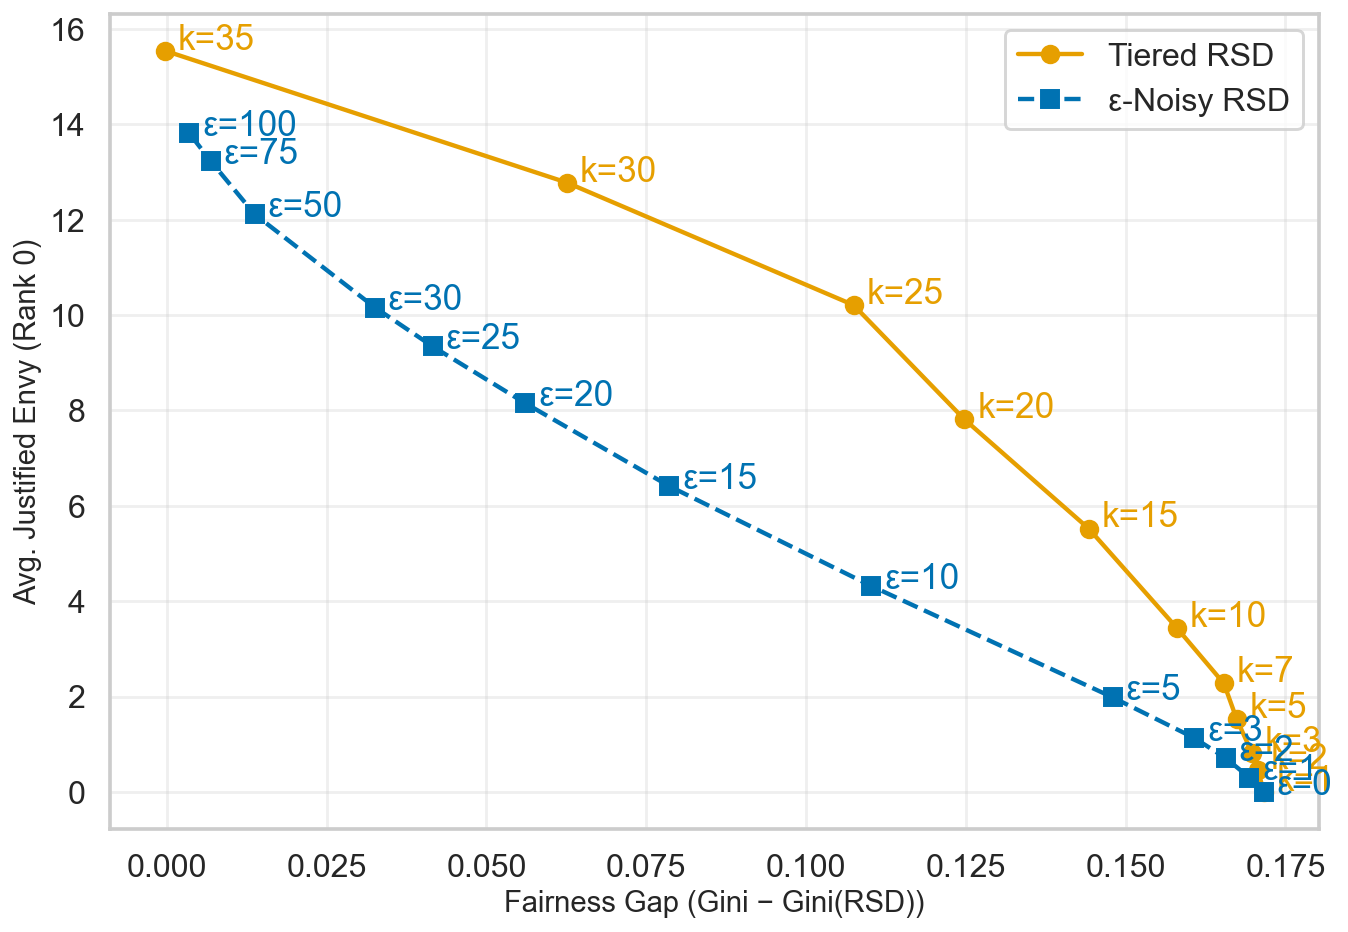

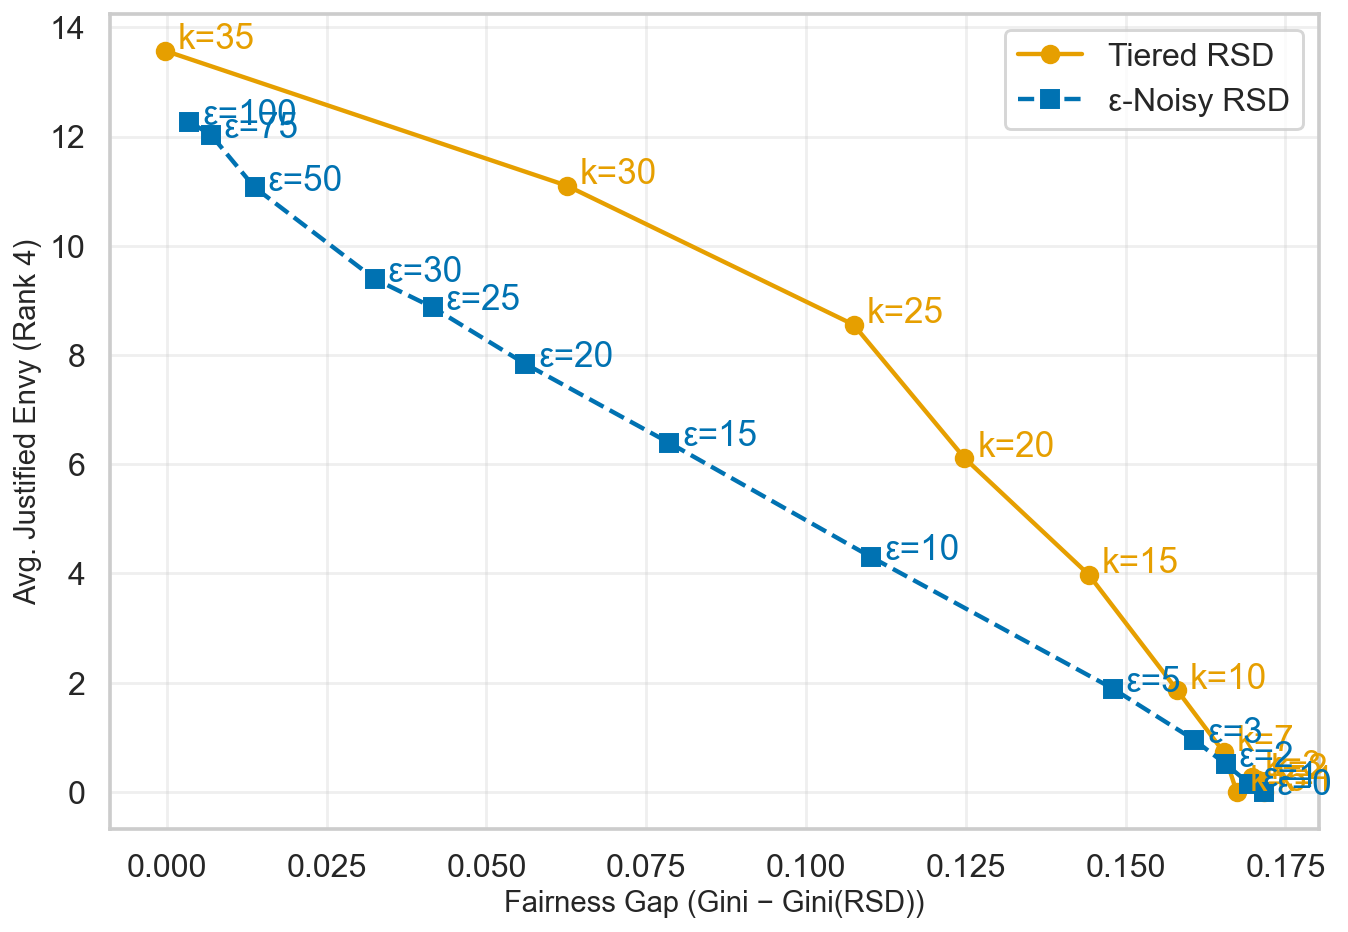

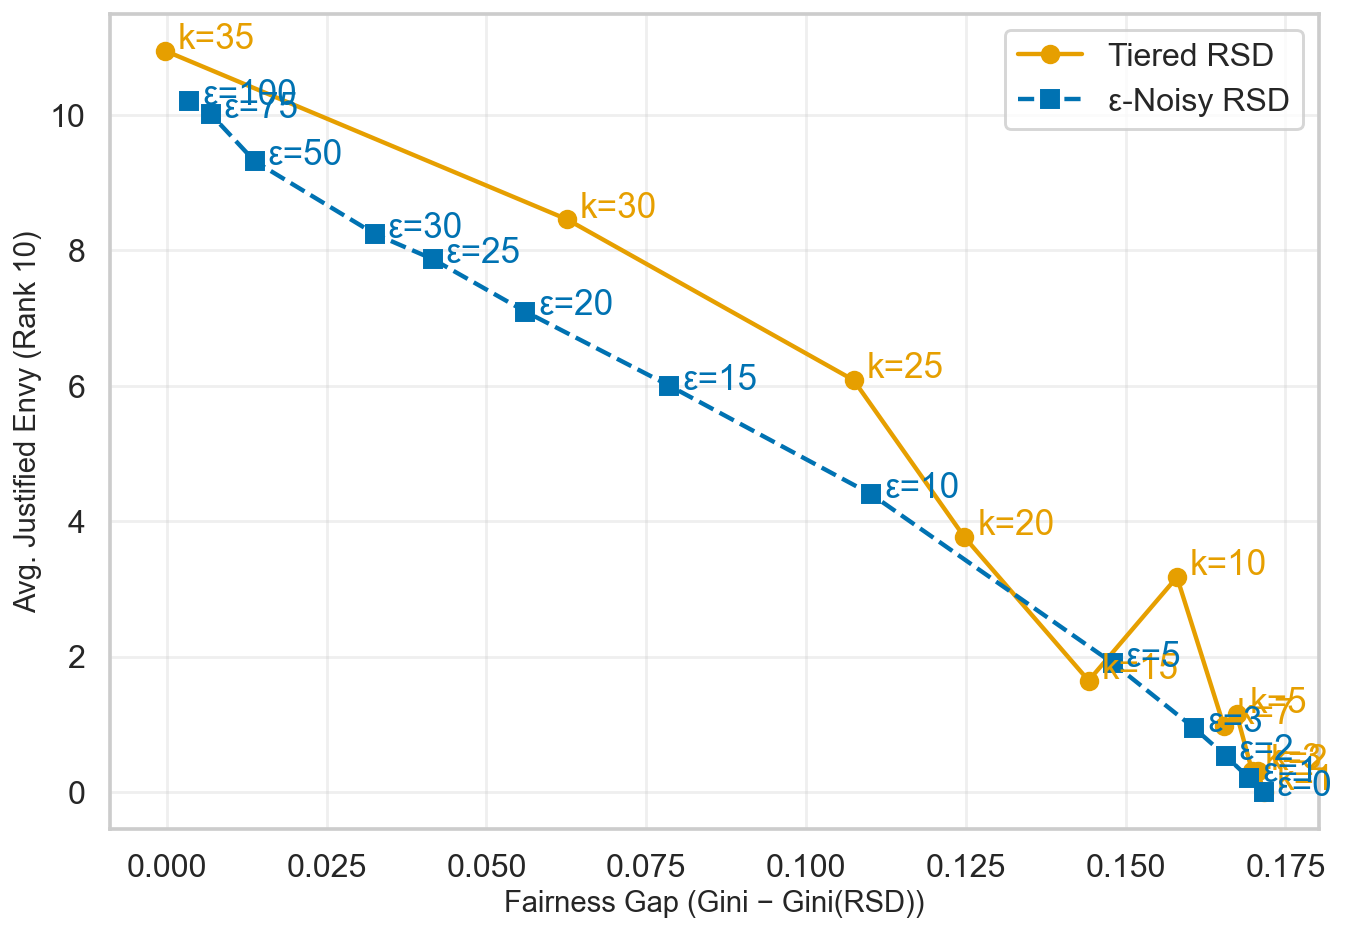

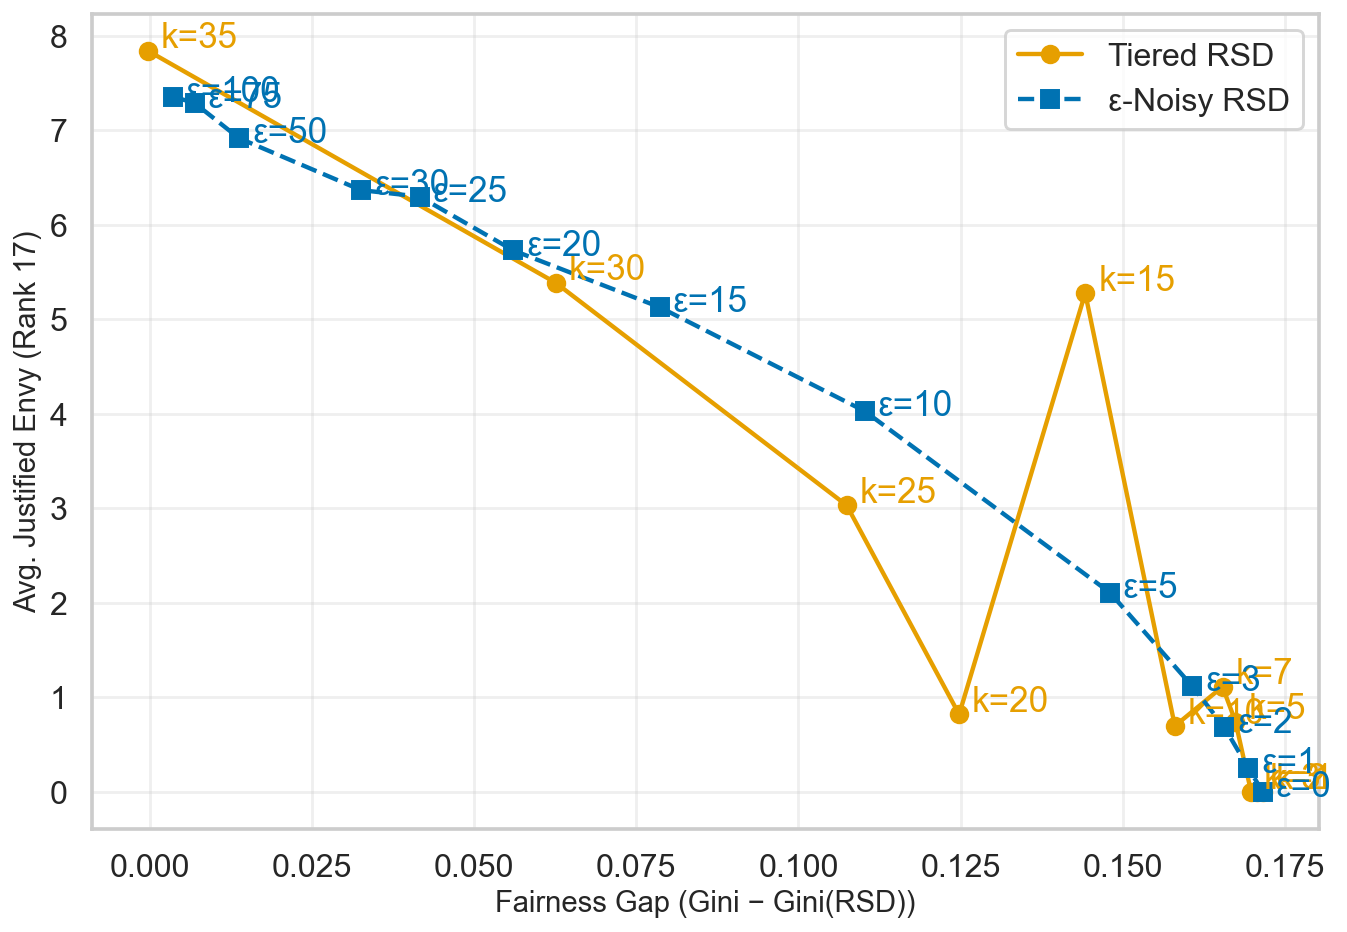

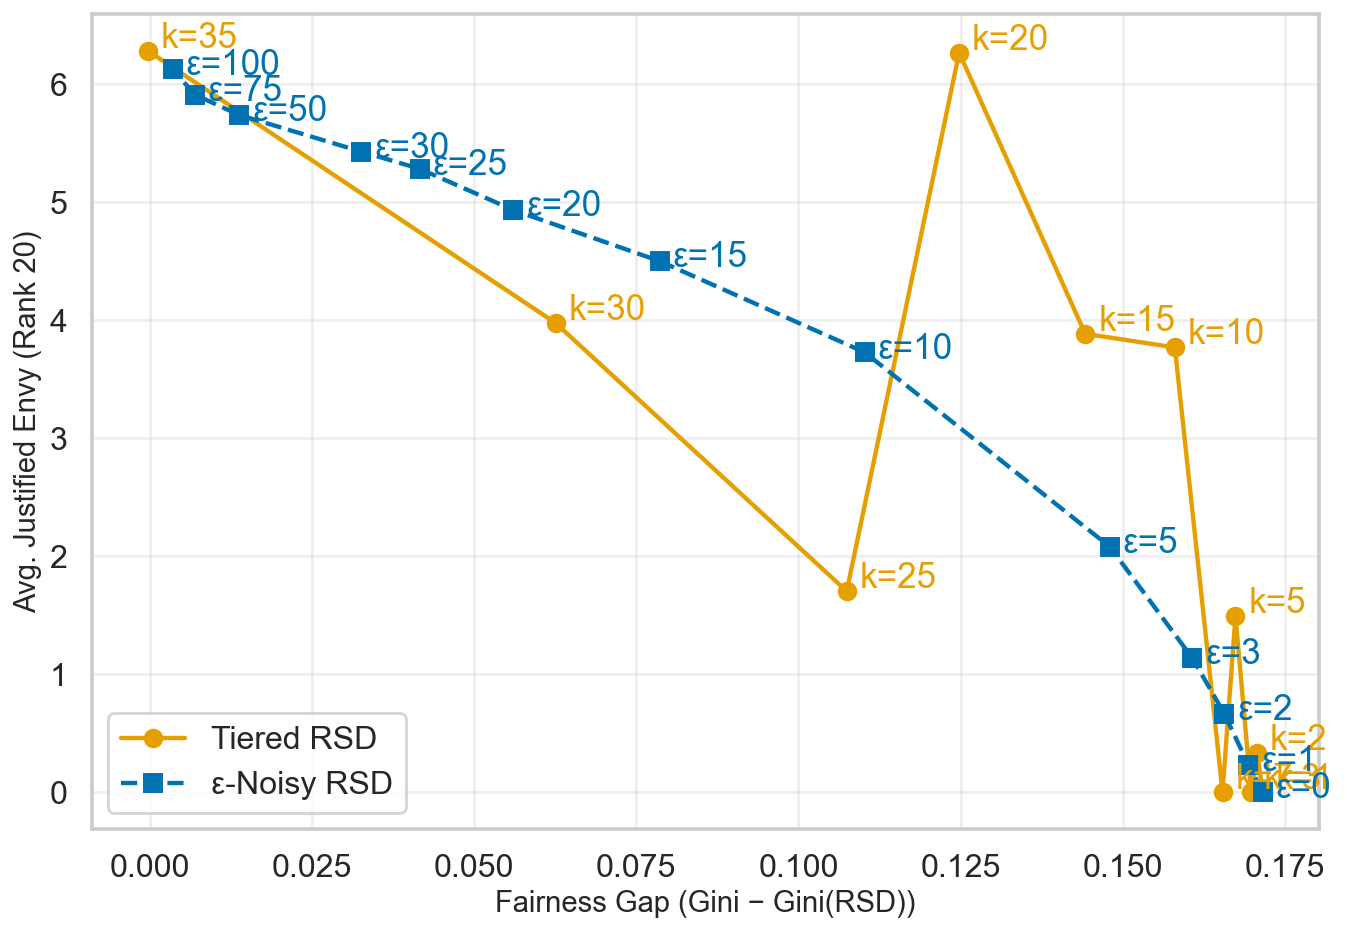

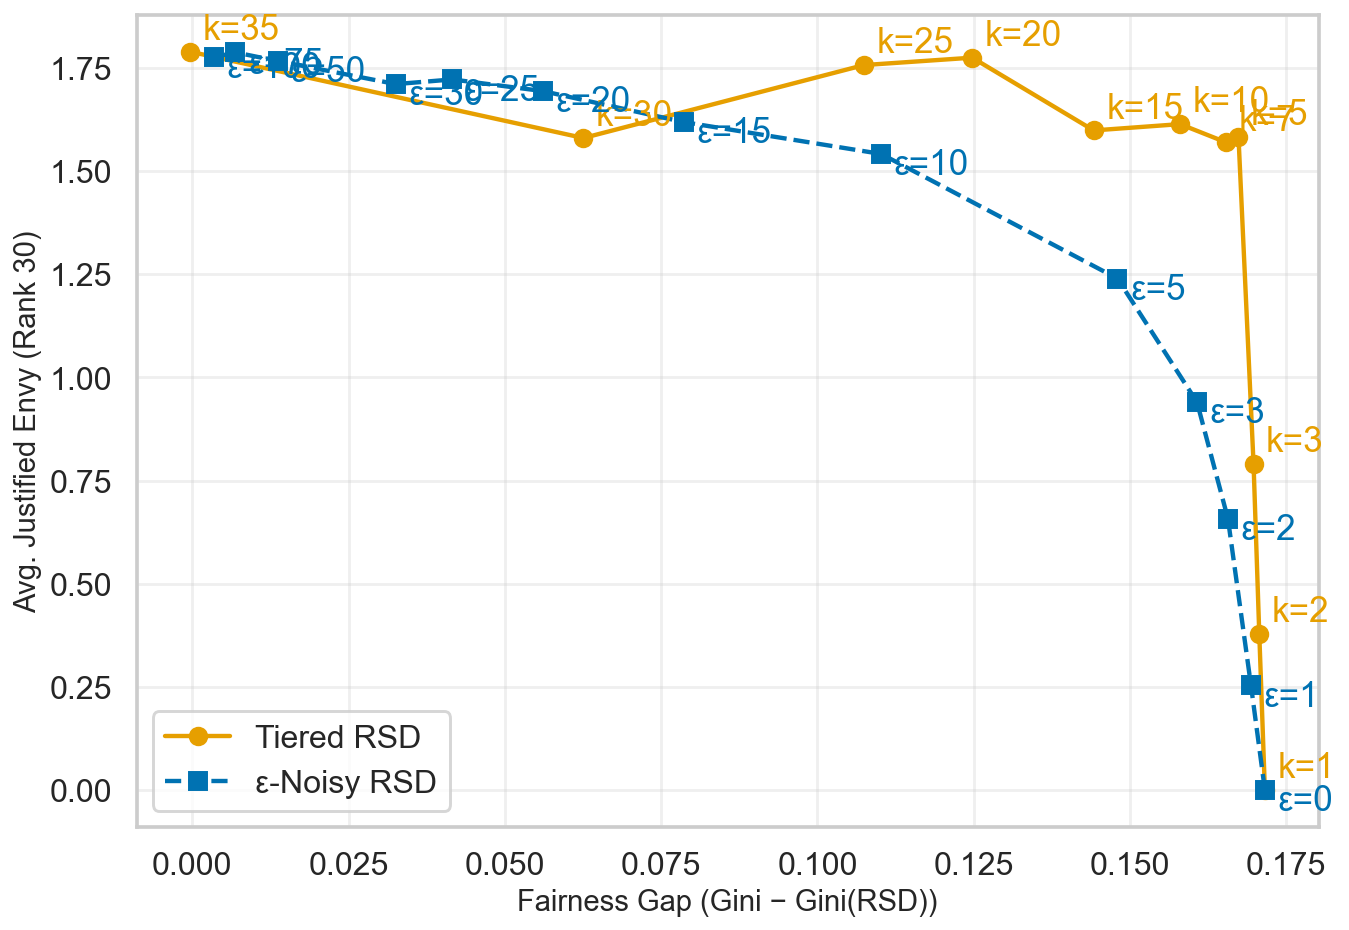

In [155]:
ranks_to_plot = [0, 4, 10, 17, 20, 30]

for r in ranks_to_plot:
    plot_fairness_envy_frontier(r, k_values, eps_values, mean_gap_k, mean_gap_eps, mean_envies_k, mean_envies_eps)